# Modelling the generic power curve as a function of rotor area and nominal power as well as environmental chararcteristics 


A wind turbine’s power curve relates its power production to the wind speed it experiences. The typical
shape of a power curve is well known and has been studied extensively; however, the power curves of
individual turbine models can vary widely from one another. This is due to both the technical features of
the turbine (power density, cut-in and cut-out speeds, limits on rotational speed and aerodynamic efficiency),
and environmental factors (turbulence intensity, air density, wind shear and wind veer). Data on individual
power curves are often proprietary and only available through commercial databases.
We therefore develop an open-source model which can generate the power curve of any turbine, adapted
to the specific conditions of any site. This can employ one of six parametric models advanced in the
literature, and accounts for the eleven variables mentioned above. 

Yves-Marie Saint-Drenan, Romain Besseau, Malte Jansen, Iain Staffell, Alberto Troccoli, Laurent Dubus, Johannes Schmidt, Katharina Gruber, Sofia G. Simões, Siegfried Heier, A parametric model for wind turbine power curves incorporating environmental conditions, Renewable Energy,,Volume 157,2020,Pages 754-768,ISSN 0960-1481,
https://doi.org/10.1016/j.renene.2020.04.123.


Addition with respect to initial paper:
 *  convolution of the wind turbine power curve for regional application following Hannele Holttinen's paper

In [24]:
import numpy as np
import matplotlib.pyplot as plt

## Parametric model of the power coefficient C$_p$(λ, β)

In [25]:
def CpLambdaModels(Model,TSR,Beta=[]):
    
    vSources=['Slootweg et al. 2003','Heier 2009','Thongam et al. 2009','De Kooning et al.  2010','Ochieng et Manyonge 2014','Dai et al. 2016']
    
    TSR=np.maximum(0.0001,TSR)
    
    if Beta==[]:
        Beta=np.zeros(TSR.shape)
                      
    if Model=='Slootweg et al. 2003':
        c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.73,151,0.58,0,0.002,13.2,18.4,0,-0.02,0.003
        x=2.14
    elif  Model=='Heier 2009':
        c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0.4,0,0,5,21,0,0.089,0.035
        x=0
    elif  Model=='Thongam et al. 2009':
        c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5176,116,0.4,0,0,5,21,0.006795,0.089,0.035
        x=0
    elif  Model=='De Kooning et al. 2010':
        c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.77,151,0,0,0,13.65,18.4,0,0,0
        x=0
    elif  Model=='Ochieng et Manyonge 2014':
        c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0,0.4,0,5,21,0,0.08,0.035
        x=0
    elif  Model=='Dai et al. 2016':
        c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.22,120,0.4,0,0,5,12.5,0,0.08,0.035
        x=0

    Li=1/(1/(TSR+c9*Beta)-c10/(Beta**3+1));
    Cp=np.maximum(0,c1*(c2/Li-c3*Beta-c4*Li*Beta-c5*Beta**x-c6)*np.exp(-c7/Li)+c8*TSR);
    
    return Cp

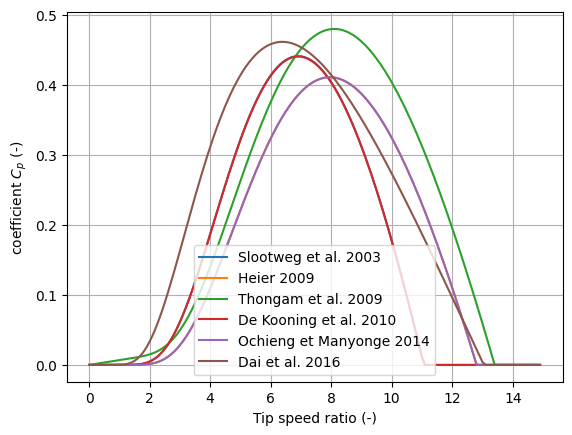

In [87]:
TSR=np.arange(0,15,0.1)
for Model in ['Slootweg et al. 2003','Heier 2009','Thongam et al. 2009','De Kooning et al. 2010','Ochieng et Manyonge 2014','Dai et al. 2016']:
    Cp=CpLambdaModels(Model,TSR,Beta=[])
    plt.plot(TSR,Cp,label=Model)    
plt.xlabel('Tip speed ratio (-)')
plt.ylabel('coefficient $C_p$ (-)')
plt.grid()
plt.legend()

## Calculation of the wind turbine curve without environmental effect

In [89]:
def WT_PowerCurve_raw(Vws,Pnom,Drotor,Vcutin=3,Vcutoff=25,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225):

    Rrotor = Drotor/2
    Arotor = np.pi*Rrotor**2

    # ********************************************************************************************
    # 1) Parameterisation of the minimal and maximal rotor rotational speed as a
    # function of the rotor diameter + calculation of VtipMin & VtipMax
    # source: http://publications.lib.chalmers.se/records/fulltext/179591/179591.pdf
    # ********************************************************************************************
    if rMin==[]:
        rMin=188.8*Drotor**(-0.7081)   # minimal angular speed in rpm
    if rMax==[]:
        rMax=793.7*Drotor**(-0.8504);      # maximal angular speed in rpm
    VtipMin=rMin*(2*np.pi*Rrotor)/60   # minimal tip speed in m/s
    VtipMax=rMax*(2*np.pi*Rrotor)/60  # maximal tip speed in m/s
    
    # ********************************************************************************************
    # 2) Calculation of the tip speed as a function of the wind speed 
    # ********************************************************************************************
    # In ths calculation step, the following assumptions are made:
    # a) the tip speed is set to maximize the energy output (*),
    #    which is achieved by setting lambda to lambdaopt, 
    # b) and assuming that Vtip is always comprised between VtipMin and VtipMax (**)
    # c) using an expression of cp as a function of lambda from (***) (no pitch control
    # assumed (**))
    # Sources:
    # (*) http://mstudioblackboard.tudelft.nl/duwind/Wind%20energy%20online%20reader/Static_pages/Cp_lamda_curve.htm
    # (**) http://www.mdpi.com/1996-1073/10/3/395
    # (***)http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6699403

    # Calculation of the optimal tip speed ratio and maximal power coefficient
    vTSR=np.arange(0,12,0.001)
    vCp=CpLambdaModels(Model,vTSR,Beta)
    TSR_Opt=np.mean(vTSR[vCp==max(vCp)])
    
    # scaling of the power coefficient function if a value is given for CpMax
    if CpMax==[]:
        CpScale=1
        CpMax=max(vCp)
    else:
        CpScale=CpMax/max(vCp)
    
    # Calculation of the tip speed and the tip speed ratio
    Vtip=np.minimum(VtipMax,np.maximum(VtipMin,TSR_Opt*Vws))
    TSR=np.zeros(Vws.shape)
    TSR[Vws>0]=Vtip[Vws>0]/Vws[Vws>0]
        
    # Calculation of the power coefficient
    Cp0=np.maximum(0,CpScale*CpLambdaModels(Model,TSR))

    # Calculation of the input power as a function of air density, wind speed and rotor area
    Pin=0.5*AirDensity*Arotor*(Vws**3)/1000
    Cp=np.zeros(Pin.shape)
    Cp[Pin>0]=np.minimum(Cp0[Pin>0],Pnom/Pin[Pin>0])
    Pout = Cp*Pin

    return Pout

Text(0.5, 1.0, 'Power curve calculated for a wind turbine  with a nominal \n power of 4.0 MW and a rotor diameter of 120 m \n (without consideration of environmental effects and Vcutin/Vcutout)')

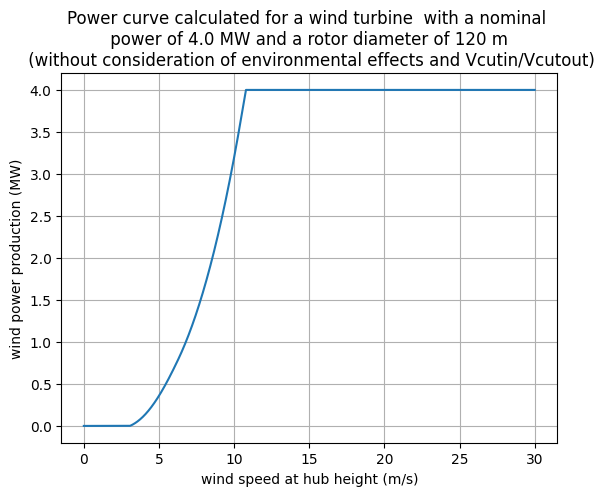

In [90]:
rMin    = 4
rMax    = 13
Drotor  = 120
Pnom    = 4000
Vws     = np.arange(0,30,0.001)

Pwt=WT_PowerCurve_raw(Vws,Pnom,Drotor,Vcutin=3,Vcutoff=25,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',AirDensity=1.225)
plt.plot(Vws,Pwt/1000)
plt.grid()
plt.xlabel('wind speed at hub height (m/s)')
plt.ylabel('wind power production (MW)')
plt.title('Power curve calculated for a wind turbine  with a nominal \n power of {} MW and a rotor diameter of {} m \n (without consideration of environmental effects and Vcutin/Vcutout)'.format(Pnom/1000,Drotor))

## Consideration of the environmental effects

### Turbulence intensity

In [ ]:
WT_PwC.PoutTI=[];
Pout0=reshape(Pout,[],1);
Vws=reshape(Vws,[],1);
if TI>0

CoeffWS=1+linspace(-3*TI/100,3*TI/100,100);
Pout_TI=zeros(size(Pout0));
SumW=zeros(size(Pout0));
tt0=[];
tt1=[];
tt2=[];
for iiK=1:length(CoeffWS)
    varVws=CoeffWS(iiK)*Vws;
    STD=TI*Vws;
    varW=1./sqrt(2*pi*STD.^2).*exp(-0.5*((varVws-Vws)./STD).^2);
    tPout=interp1([-100;Vws;100],[0;Pout0;Pout0(end)],varVws);
    tt0=[tt0,varVws(21)];
    tt1=[tt1,varW(21)];
    tt2=[tt2,tPout(21)];
    Pout_TI=Pout_TI+varW.*tPout;
    SumW=SumW+varW;
end
WT_PwC.PoutTI=Pout_TI./SumW;
else
    WT_PwC.PoutTI=Pout;
end
%%
WT_PwC.PoutTI(WT_PwC.Vws>Vcutoff)=0;
WT_PwC.PoutTI(WT_PwC.Vws<Vcutin)=0;
WT_PwC.Pout(WT_PwC.Vws>Vcutoff)=0;
WT_PwC.Pout(WT_PwC.Vws<Vcutin)=0;

### Wind shear

In [ ]:
rMin = 4
rMax = 13
Drotor  = 120
Pnom    = 4000
Vws     = np.arange(0,30,0.001)

Pout=Eval_WT_PowerCurve_v3(WT_param,Vws);
hold on
plot(WT_PowerCurve.Vws,WT_PowerCurve.Pout)

subplot(2,1,1)
hold on
plot(WT_PowerCurve.Vws,WT_PowerCurve.Cp,WT_PowerCurve.Vws,WT_PowerCurve.Pnom./WT_PowerCurve.Pin,'--',WT_PowerCurve.Vws,WT_PowerCurve.Cp)
xlabel('wind speed at hub height [m/s]')
ylabel('Power coefficient Cp [-]')
ylim([0 1])
grid on
subplot(2,1,2)
hold on
plot(WT_PowerCurve.Vws,WT_PowerCurve.Pout)
xlabel('wind speed at hub height[m/s]')
ylabel('wind turbine output power [kW]')
grid on
%}

### Wind veer